In [1]:
# Transfer Learning(전이학습) 
# Kaggle Face Mask Detection Classification - Kaggle 얼굴에 마스크(face mask detection) 여부 분류

In [2]:
# 1) import, GPU 설정
import torch
from torch import nn
from torchvision import models, transforms, datasets # 다양한 사전 학습 모델을 포함한 모듈
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os, shutil, zipfile, random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.2.2 , device :  cpu


In [3]:
# 2) 데이터 다운로드 - Kaggle Face Mask Dataset
# 데이터 폴더 존재시 삭제
if os.path.exists('./data/face_mask'):
    shutil.rmtree('./data/face_mask')
    print('./data/face_mask is removed')

./data/face_mask is removed


In [4]:
# 3) 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/face_mask_dataset.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/face_mask_dataset.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/face_mask_dataset.zip')
    with zipfile.ZipFile('./data/face_mask_dataset.zip', 'r') as target_file:
        target_file.extractall('./data/')
        print('압축 해제 완료. ./data/face_mask_dataset.zip')

압축 파일 존재함. ./data/face_mask_dataset.zip
압축 해제 완료. ./data/face_mask_dataset.zip


In [5]:
# 4) 데이터 경로 설정
ROOT_DIR = './data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'face_mask')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [6]:
# 5) 데이터 전처리 설정
# train
train_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.RandomHorizontalFlip(), # 이미지 좌우반전 50% 효과
                                   transforms.ToTensor(), # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
                                 ])
# validation
validation_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.ToTensor(), # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
                                 ])
# test
test_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.ToTensor(), # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
                                 ])

In [7]:
# 6) 데이터셋 생성- ImageFolder 사용 → 폴더 구조 기반으로 자동 라벨링
train_dataset = datasets.ImageFolder(root=TRAIN_DATA_ROOT_DIR, transform=train_config) # train dataset
validation_dataset = datasets.ImageFolder(root=VALIDATION_DATA_ROOT_DIR, transform=validation_config) # validation dataset
test_dataset = datasets.ImageFolder(root=TEST_DATA_ROOT_DIR, transform=test_config) # test dataset

In [8]:
# 7) 데이터로더 설정
BATCH_SIZE = 16
# num_workers=4 - 데이터를 로딩할 때 사용할 CPU 프로세스 수, 일반적으로 CPU 코어 수 / 2 또는 4~8 추천, pin_memory=True - GPU 사용 시 데이터를 고정된 메모리로 올려서 전송 속도 향상, - x.to(DEVICE) 할 때 더 빠르게 복사됨
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

torch.Size([16, 3, 224, 224]) torch.Size([16])
{0: 'WithMask', 1: 'WithoutMask'}


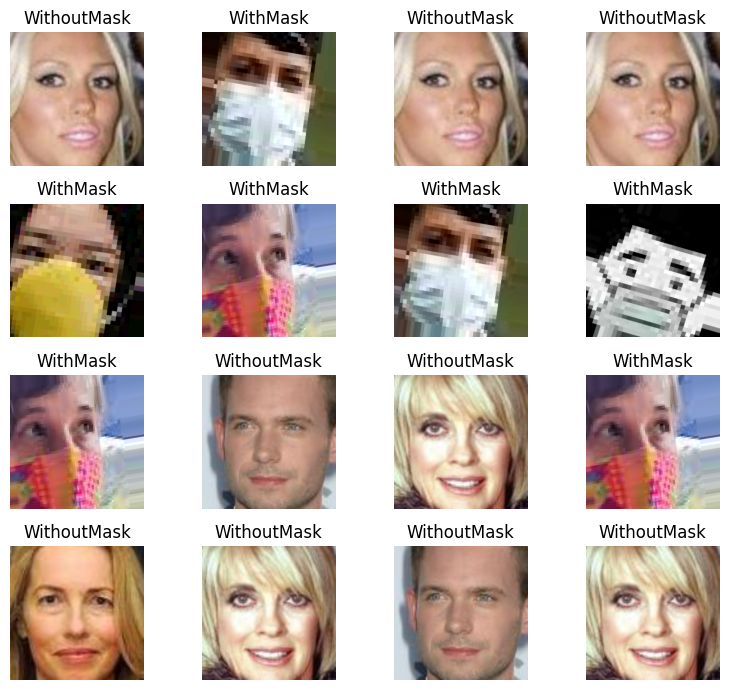

In [9]:
# 8) 데이터 확인
images, labels = next(iter(train_dataset_loader)) # - train_dataset_loader로 변경, 1개 배치 추출
print(images.shape, labels.shape)

labels_map = { v : k for k, v in train_dataset.class_to_idx.items() } # - train_dataset.class_to_idx 사용
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    # - torch.randint()는 0부터 high - 1 사이의 정수를 생성
    # - len(images)는 현재 배치에 포함된 이미지 수예요. 예를 들어 BATCH_SIZE = 32이면 len(images)는 32
    # - size = (1,) 생성할 정수의 **개수와 형태(shape)**를 지정, (1,)은 1개의 정수를 담은 1차원 텐서를 의미, 예시: tensor([17]) 결과
    sample_idx = torch.randint(len(images), size=(1, )).item() # 0~31 사이의 정수 중 하나를 랜덤하게 생성
    img, label = images[sample_idx], labels[sample_idx].item() # - 이미지와 라벨 추출

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    img = img * std + mean # 정규화된 이미지 복원
    
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0))) # (C, H, W) -> (H, W, C) 순서 변경
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# from collections import Counter
# print(Counter([label for _, label in train_dataset]))

Counter({0: 5000, 1: 5000})


In [10]:
# 9) Transfer Learning Model - ResNet
class TransferLearningModel(nn.Module):
    def __init__(self, base_model, feature_extractor, num_classes=2):
        super().__init__()
        # ViT는 encoder.layer.N 형태로 여러 Transformer 블록을 포함하고 있으며 예를 들어 아래처럼 일부만 동결
        # - 예시) encoder.layer.0~3까지 freeze → 일반적인 특징 유지
        # - 예시) encoder.layer.4~11은 fine-tune → 데이터셋에 맞게 조정
        if(feature_extractor):
            for name, param in base_model.named_parameters():
                # if 'encoder.layer.0' in name or 'encoder.layer.1' in name: # Vision Transformer 기반 구조 
                if 'layer1' in name or 'layer2' in name or 'conv1' in name: # ResNet 기반 구조
                    param.requires_grad = False  # 초기 레이어 동결
                else:
                    param.requires_grad = True   # 나머지 레이어는 학습
                    
        # base_model.heads = nn.Sequential(
        #     nn.Linear(base_model.heads[0].in_features, 256), # pretrained_model.heads를 새로 정의 → 기존 MLP Head를 커스터마이징하여 2개 클래스 분류에 맞춤
        #     nn.ReLU(), # 활성화 함수
        #     nn.Dropout(p=0.5), # 드롭아웃
        #     nn.Linear(256, 64), # 은닉층
        #     nn.ReLU(), 
        #     nn.Dropout(p=0.5),
        #     nn.Linear(64, len(train_dataset.classes)) # 최종 출력층 - 4가지 face mask 분류(classification)
        # )
        base_model.fc = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 256), # pretrained_model.fc를 새로 정의 → 기존 MLP Head를 커스터마이징하여 2개 클래스 분류에 맞춤
            nn.ReLU(), # 활성화 함수
            nn.Dropout(p=0.5), # 드롭아웃
            nn.Linear(256, 64), # 은닉층
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes) # 최종 출력층 - 2가지 face mask 분류(classification)
        )
        self.model = base_model
    
    def forward(self, x):
        x = self.model(x) # - 사전학습된 모델의 순전파 메서드 호출
        return x

# 전체 레이어 이름 확인(디버깅용)
# for name, param in base_model.named_parameters():
#     print(name, param.requires_grad)

In [11]:
# 10) EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='./models/model_transfer_learning_face_mask_detection.pt'):
        self.patience = patience          # 개선되지 않아도 기다릴 epoch 수
        self.verbose = verbose            # 개선 시 출력 여부
        self.counter = 0                  # 개선되지 않은 epoch 수
        self.best_score = None            # 최고 성능 점수
        self.early_stop = False           # 중단 여부
        self.val_loss_min = float('inf')  # 최소 validation loss
        self.delta = delta                # 개선 최소 차이
        self.path = path                  # 모델 저장 경로

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Validation loss가 감소하면 모델 저장'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:
# 11) 모델, 손실함수, 옵티마이저 객체생성 및 하이퍼라마미터 설정
# base_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT) # Vision Transformer(ViT) 모델을 ImageNet 사전학습 가중치로 불러오는 코드
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # ResNet 모델을 사전학습 가중치로 불러옴.
feature_extractor = True # - feature_extractor = False → fine-tuning 모드로 전체 모델 학습
num_classes = 2
model = TransferLearningModel(base_model=base_model, feature_extractor=feature_extractor, num_classes=num_classes).to(DEVICE) # - model 객체 생성
loss_function = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer

print(model) # - 모델 구조 출력

TransferLearningModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [13]:
# 12) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0 # train loss 합
    train_correct = 0 # train 맞춘 개수
    train_total = 0 # train 전체 개수
    total_train_batch = len(dataloader) # 전체 배치 개수
    for images, labels in dataloader: # dataloader에서 배치 단위로 이미지와 라벨 추출        
        x_train = images.to(DEVICE) # GPU로 데이터 전송
        y_train = labels.to(DEVICE)
        
        outputs = model(x_train) # 모델 예측
        loss = loss_function(outputs, y_train) # 손실함수 계산

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item() # 오차 누적
        train_total += y_train.size(0) # 배치 내 샘플 개수 누적
        train_correct += (torch.argmax(outputs, dim=1) == y_train).sum().item() # - argmax로 예측값과 실제값 비교 후 맞춘 개수 누적
        
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [14]:
# 13) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)
        for images, labels in dataloader:            
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, dim=1) == y_val).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [15]:
# 14) Model test 함수
def model_test(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)
        for images, labels in dataloader:            
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, dim=1) == y_test).sum().item()
            
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)
        return test_avg_loss, test_avg_accuracy


In [16]:
# 15) Confusion Matrix(혼동행렬) 시각화 함수
def confusion_matrix_plot(dataloader, model):
    model.eval() # 추론모드
    all_labels = []
    all_preds = []
    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test) # 모델 추론
            _, preds = torch.max(outputs, 1) # 모델 예측값 추출

            all_labels.extend(y_test.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_preds.extend(preds.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    
    cm = confusion_matrix(all_labels, all_preds) # 혼동행렬(Confusion Matrix) 계산
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[labels_map[i] for i in range(len(labels_map))]) # - display_labels에 클래스 이름 전달
    plt.figure(figsize=(8, 6)) # - 그래프 크기 설정
    disp.plot(cmap=plt.cm.Blues) # - 블루 계열의 컬러맵 사용
    plt.xticks(rotation=45) # x축 라벨 45도 회전
    plt.title('Confusion Matrix') # - 타이틀 추가
    plt.show()

In [17]:
# 16) Classification Report 함수
def classification_report_plt(dataloader, model):
    model.eval() # 추론모드
    all_labels = []
    all_preds = []
    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test) # 모델 추론
            _, preds = torch.max(outputs, 1) # 모델 예측값 추출

            all_labels.extend(y_test.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_preds.extend(preds.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    
    target_names = list(labels_map.values()) # - 클래스 이름 리스트 생성
    report = classification_report(all_labels, all_preds, target_names=target_names, digits=4) # - 분류 리포트 생성, digits=4로 소수점 4자리까지 출력 → 정밀한 비교 가능

    print(report) # - 분류 리포트 출력

In [ ]:
# 17) Model 학습 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
start_time = datetime.now()
early_stopping = EarlyStopping(patience=3, verbose=True)
EPOCHS = 9 # cpu 사용시 에폭 3배이상 낮게 설정

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader, model=model, loss_function=loss_function, optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader, model=model, loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # early stopping
    early_stopping(val_loss=val_avg_loss, model=model)
    
    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

Validation loss decreased (inf → 0.000267). Saving model...
epoch :  01 train loss =  0.059860 , train acc =  98.330000 val loss =  0.000267 , val acc =  100.000000
Validation loss decreased (0.000267 → 0.000066). Saving model...
epoch :  02 train loss =  0.006012 , train acc =  99.770000 val loss =  0.000066 , val acc =  100.000000
EarlyStopping counter: 1 out of 5
epoch :  03 train loss =  0.003340 , train acc =  99.920000 val loss =  0.000450 , val acc =  100.000000
Validation loss decreased (0.000066 → 0.000033). Saving model...
epoch :  04 train loss =  0.002748 , train acc =  99.950000 val loss =  0.000033 , val acc =  100.000000
EarlyStopping counter: 1 out of 5
epoch :  05 train loss =  0.002572 , train acc =  99.920000 val loss =  0.000525 , val acc =  100.000000
Validation loss decreased (0.000033 → 0.000027). Saving model...
epoch :  06 train loss =  0.003504 , train acc =  99.890000 val loss =  0.000027 , val acc =  100.000000
Validation loss decreased (0.000027 → 0.000005)

In [19]:
# 19) 테스트 데이터셋 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader, model=model, loss_function=loss_function)

accuracy =  99.8991935483871 , loss =  0.005830531915838603


(0.005830531915838603, 99.8991935483871)

<Figure size 800x600 with 0 Axes>

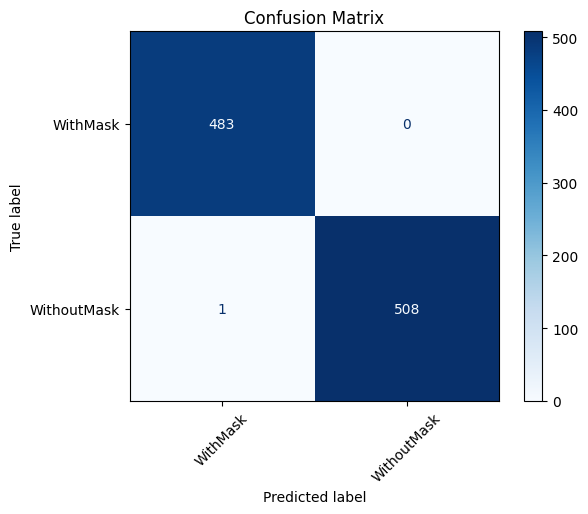

In [20]:
# 20) Confusion Matrix(혼동행렬) 시각화
confusion_matrix_plot(dataloader=test_dataset_loader, model=model)

In [21]:
# 21) clssification report 출력
classification_report_plt(dataloader=test_dataset_loader, model=model)

              precision    recall  f1-score   support

    WithMask     0.9979    1.0000    0.9990       483
 WithoutMask     1.0000    0.9980    0.9990       509

    accuracy                         0.9990       992
   macro avg     0.9990    0.9990    0.9990       992
weighted avg     0.9990    0.9990    0.9990       992



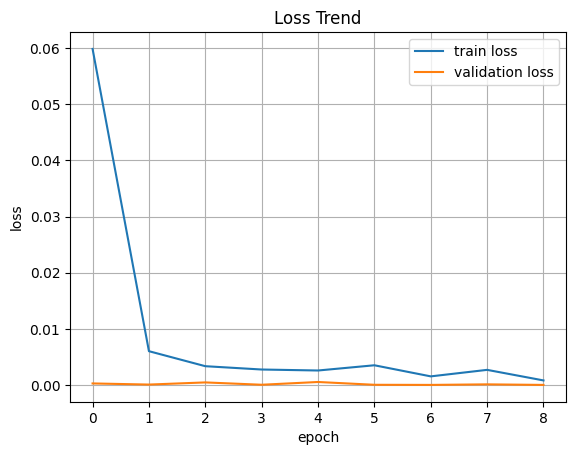

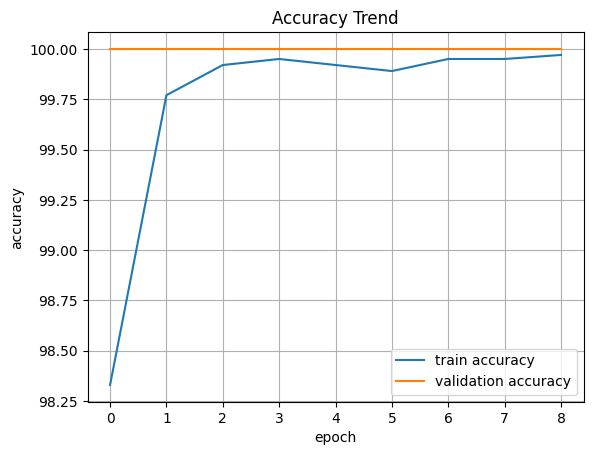

In [22]:
# 22) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [23]:
# 23) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_transfer_learning_face_mask_detection.pt')

In [24]:
# 24) 테스트 - 모델 추론 및 예측값 추출
BATCH_SIZE = 32

# test dataloaer 생성
test_image_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_images, test_labels = next(iter(test_image_loader)) # 1개 배치 추출

x_test = test_images.to(DEVICE) # - GPU로 데이터 이동
y_test = test_labels.to(DEVICE)

outputs = model(x_test) # 모델 추론
_, preds = torch.max(outputs, 1) # 모델 예측값 추출

{0: 'WithMask', 1: 'WithoutMask'}


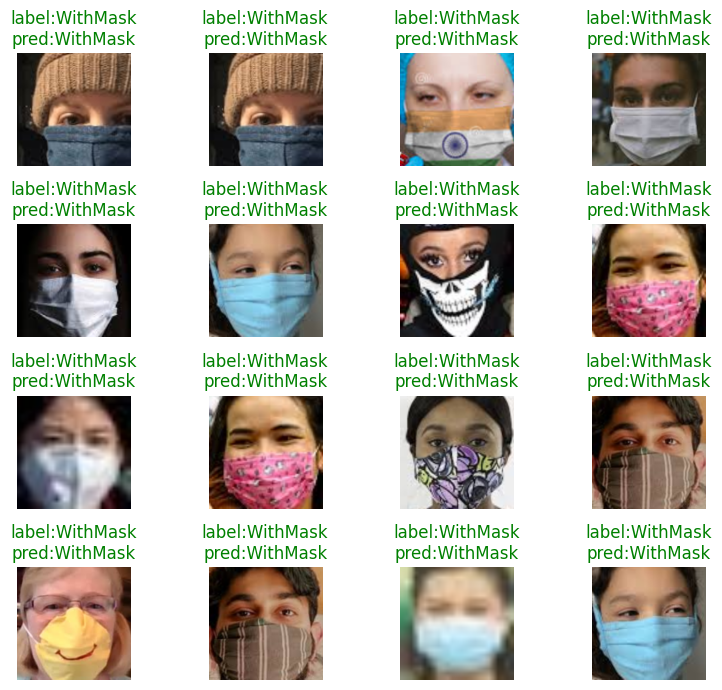

In [25]:
# 25) 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    img = img * std + mean # 정규화된 이미지 복원
    img = img.clamp(0, 1) # 0~1 사이의 값으로 클램핑

    correct = (label == pred) # 정답 여부
    title_color = 'green' if correct else 'red' # 정답이면 녹색, 오답이면 빨간색
    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred], color=title_color) # - 정답이면 녹색, 오답이면 빨간색 타이틀 출력
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()